# List of estimators

In [1]:
import torch
import confounding_robust_inference as cri

In [2]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_2359698/966458967.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
policy = cri.policies.LogisticPolicy(beta)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(4000)

In [4]:
ipw = cri.estimators.IPWEstimator().fit(Y, T, X, p_t, policy).predict()
true_ipw = data.evaluate_policy(policy)
true_lower_bound = data.evaluate_policy_lower_bound(policy, Gamma=1.5)
bias = ipw - true_ipw

def remove_finite_sample_bias(ests):
    return [x - bias for x in ests]

In [5]:
def estimator_factory(estimator_name, Gamma):
    return {
        "Hajek": cri.estimators.HajekEstimator(),
        "IPW": cri.estimators.IPWEstimator(),
        "ZSB": cri.estimators.ZSBEstimator(const_type="Tan_box", Gamma=Gamma),
        "KCMC": cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30),
        "GP-KCMC": cri.estimators.GPKCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30),
        "KCMC-SGD": cri.estimators.DualKCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=30),
        "NCMC-SGD": cri.estimators.DualNCMCEstimator(const_type="Tan_box", Gamma=Gamma),
        "QB": cri.estimators.QBEstimator(const_type="Tan_box", Gamma=Gamma, D=30),
    }[estimator_name]

In [6]:
def plot_bound_tightness(estimator_name):
    def get_lower_bound(Gamma):
        estimator = estimator_factory(estimator_name, Gamma)
        estimator.fit(Y, T, X, p_t, policy)
        return estimator.predict()
    
    def get_upper_bound(Gamma):
        estimator = estimator_factory(estimator_name, Gamma)
        estimator.fit(-Y, T, X, p_t, policy)
        return - estimator.predict()
        
    Gammas = [1 + i / 10 for i in range(11)]
    lower_bounds = [get_lower_bound(Gamma) for Gamma in Gammas]
    upper_bounds = [get_upper_bound(Gamma) for Gamma in Gammas]
    
    plt.plot(Gammas, lower_bounds, color=tab10(0))[0]
    plt.plot(Gammas, upper_bounds, color=tab10(0))[0]
    plt.xlabel(r"Sensitivity parameter $\Gamma$")
    plt.ylabel(r"Policy value")
    plt.savefig(f'fig/list_estimators_{estimator_name}.pdf')

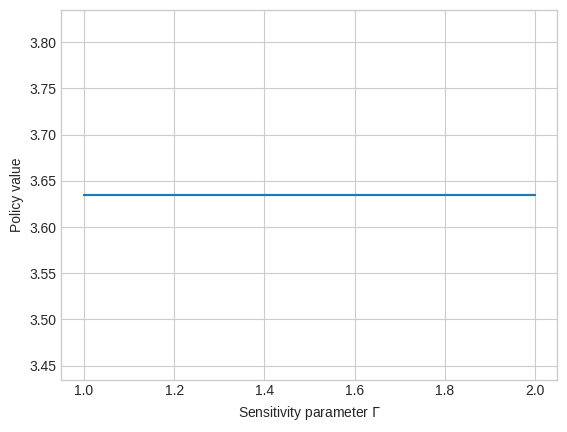

In [7]:
plot_bound_tightness("IPW")

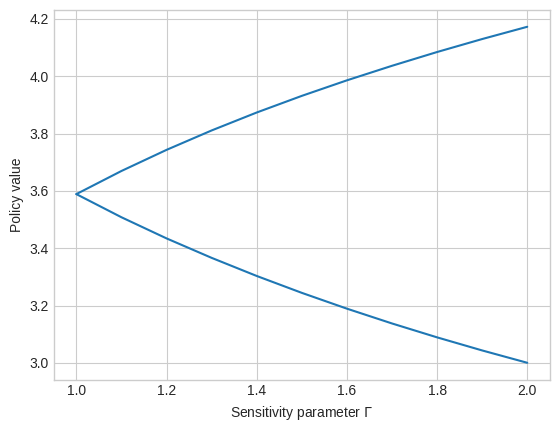

In [8]:
plot_bound_tightness("ZSB")

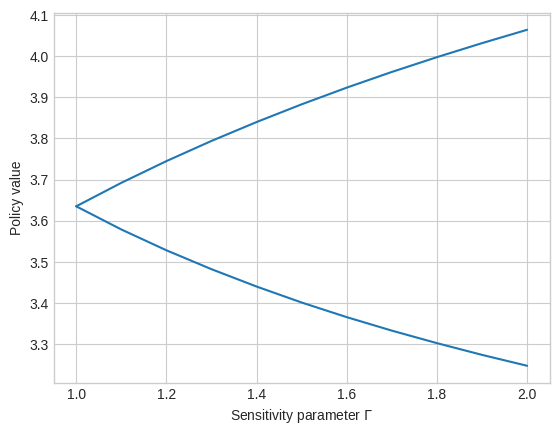

In [9]:
plot_bound_tightness("KCMC")

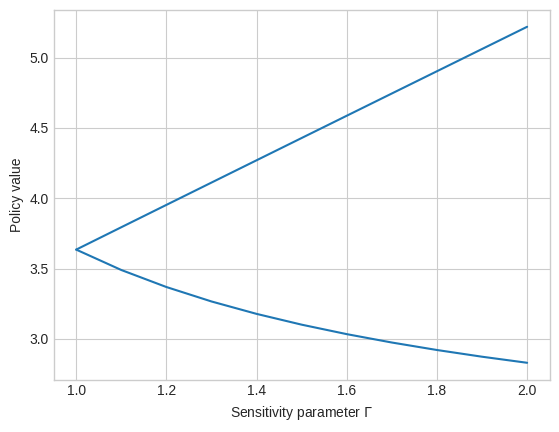

In [10]:
plot_bound_tightness("KCMC-SGD")

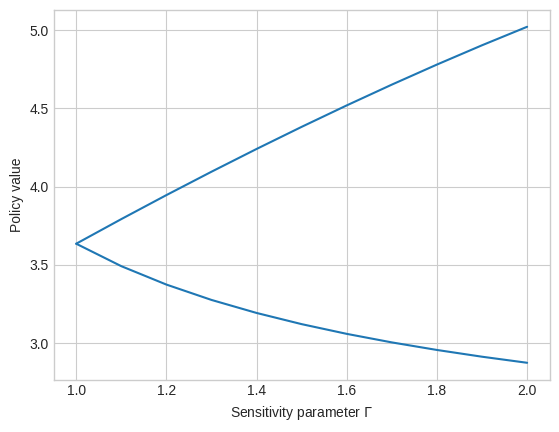

In [11]:
plot_bound_tightness("NCMC-SGD")

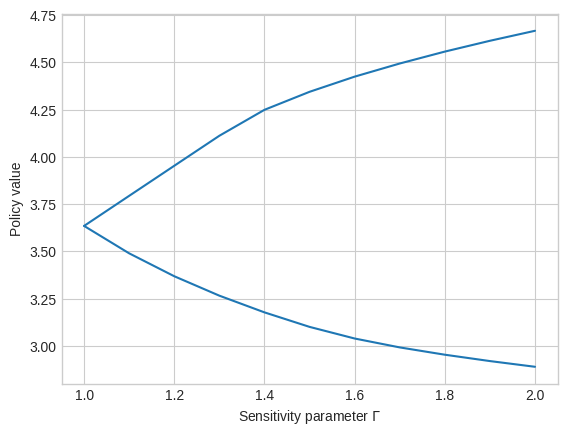

In [12]:
plot_bound_tightness("GP-KCMC")

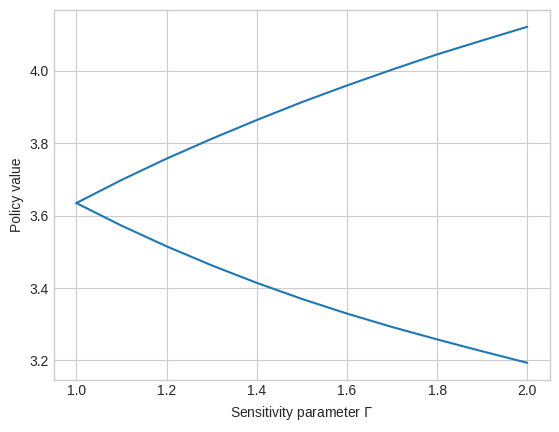

In [13]:
plot_bound_tightness("QB")